In [1]:
!pip install ucimlrepo
!pip install optuna
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 26.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from os import pipe
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import train_test_split,cross_val_score
import shap
import optuna
import sklearn.metrics

In [3]:
%matplotlib inline

In [4]:
# fetch dataset
bike_sharing = fetch_ucirepo(id=275)

# data (as pandas dataframes)
X = bike_sharing.data.features
y = bike_sharing.data.targets

# metadata
print(bike_sharing.metadata)

# variable information
print(bike_sharing.variables)


{'uci_id': 275, 'name': 'Bike Sharing', 'repository_url': 'https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/275/data.csv', 'abstract': 'This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.', 'area': 'Social Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 17389, 'num_features': 13, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['cnt'], 'index_col': ['instant'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2013, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C5W894', 'creators': ['Hadi Fanaee-T'], 'intro_paper': {'title': 'Event labeling combining ensemble detectors and background knowledge', 'authors': 'Hadi Fanaee-T, João Gama', 'published_in': 'Progress in Artificial Intelli

## EDA

###Ideas for later:
1. Distinguish between casual and registered?


Exploring the data:

In [6]:
orig_df = bike_sharing.data.original
orig_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


[]

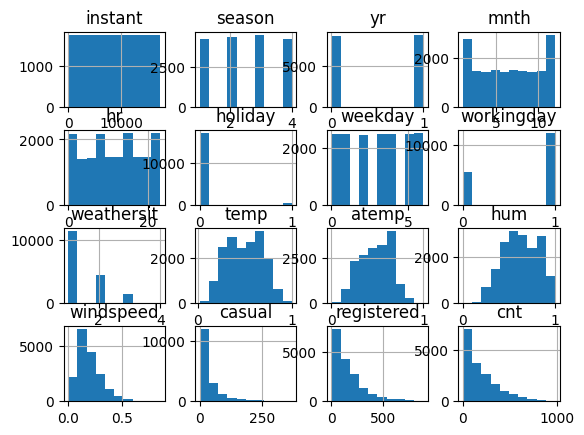

In [5]:
#Raw features histograms:
bike_sharing.data.original.hist()
plt.plot()

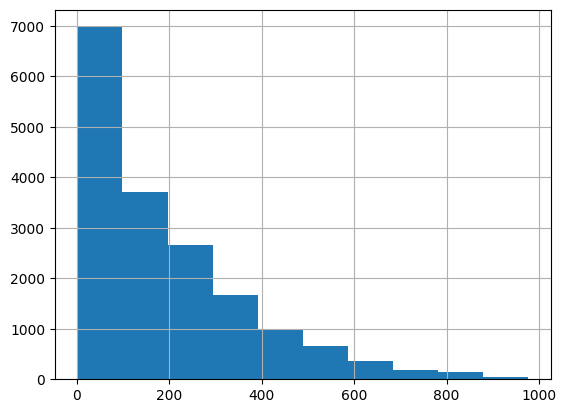

In [18]:
#We can see that y isn't distirubted in a normal way, lets try to apply ln function and see if it looks better:
orig_df.cnt.hist()
plt.show()

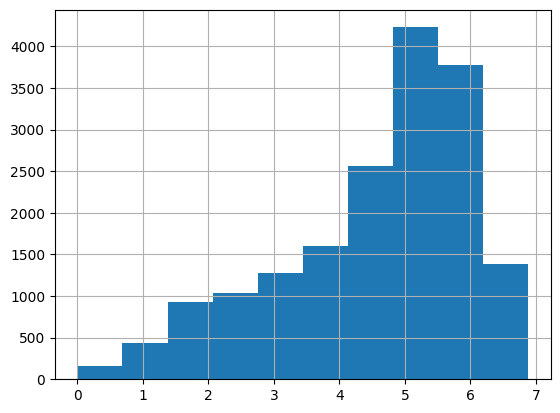

In [23]:
np.log(orig_df.cnt).hist()
plt.show()

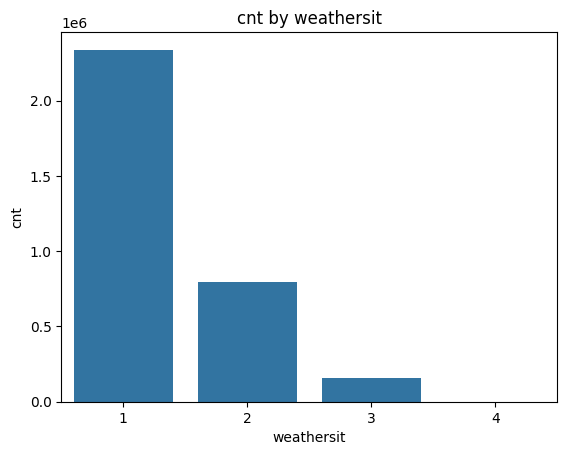

In [26]:
#Distribution of cnt along the seasons
var = 'weathersit'
season_df = orig_df.groupby(var)['cnt'].sum().reset_index()
sns.barplot(data = season_df,x = var,y = 'cnt')
plt.title(f'cnt by {var}')
plt.show()

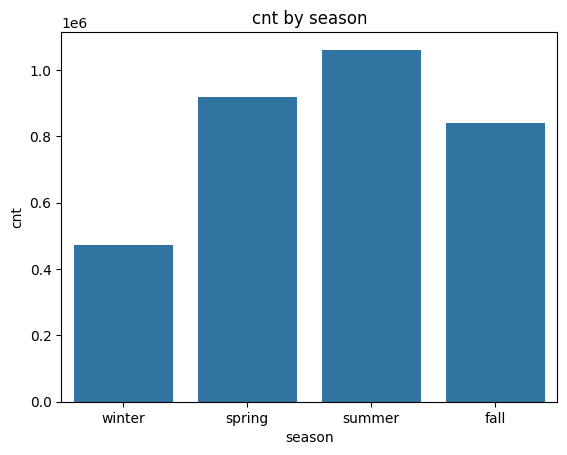

In [16]:
#Distribution of cnt along the seasons
season_map = {1:'winter', 2:'spring', 3:'summer', 4:'fall'}
season_df = orig_df.groupby('season')['cnt'].sum().reset_index()
season_df['season'] = season_df['season'].map(season_map)
sns.barplot(data = season_df,x = 'season',y = 'cnt')
plt.title('cnt by season')
plt.show()

### Remove y outliers according to the 3 sigmas rule:

In [44]:
y = y[np.abs(y['cnt'] - y['cnt'].mean()) <= 3*y['cnt'].std()]
X = X.iloc[y.index]

In [8]:
bike_sharing.data.original.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [ ]:
bike_sharing.data.original.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [24]:
clean_orig  = bike_sharing.data.original.iloc[clean_y.index]

<Axes: >

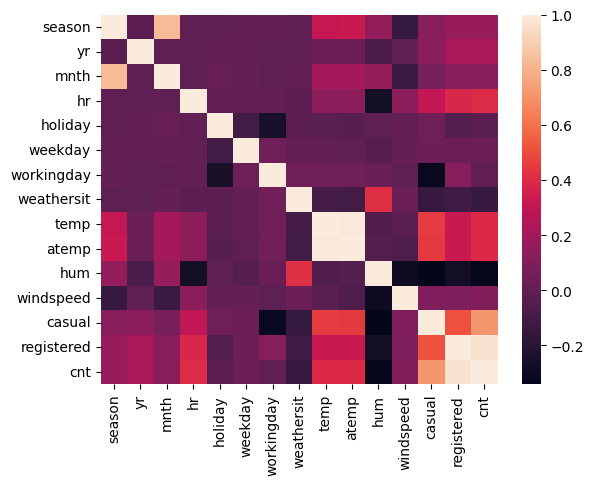

In [26]:
corr_map = clean_orig.loc[:,~clean_orig.columns.isin(['instant','dteday'])].corr()
# plot the heatmap
sns.heatmap(corr_map)

##Preprocessing time features

In [27]:
X['dteday'] = pd.to_datetime(X['dteday'])
X['day'] = X['dteday'].dt.day
X['day_sin'] = np.sin(2*np.pi*X['day']/31)
X['day_cos'] = np.cos(2*np.pi*X['day']/31)
X['hr_sin'] = np.sin(2 * np.pi * X['hr'] / 24)
X['hr_cos'] = np.cos(2 * np.pi * X['hr'] / 24)
X['month_sin'] = np.sin(2 * np.pi * X['mnth'] / 12)
X['month_cos'] = np.cos(2 * np.pi * X['mnth'] / 12)
X['season_sin'] = np.sin(2*np.pi*X['season']/4)
X['season_cos'] = np.cos(2*np.pi*X['season']/4)
# X['season'] = X['season'].astype('category')
X['weekday_sin'] = np.sin(2*np.pi*X['weekday']/7)
X['weekday_cos'] = np.cos(2*np.pi*X['weekday']/7)
X = X.drop(columns=['dteday','day','hr','mnth','weekday','season'])

<ipython-input-27-52b0288f6d09>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['dteday'] = pd.to_datetime(X['dteday'])
<ipython-input-27-52b0288f6d09>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['day'] = X['dteday'].dt.day
<ipython-input-27-52b0288f6d09>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [46]:
#Move redundent feature (in order to prevent heteroscedasticity)
X = X.drop(columns = 'temp',axis = 1)

<Axes: >

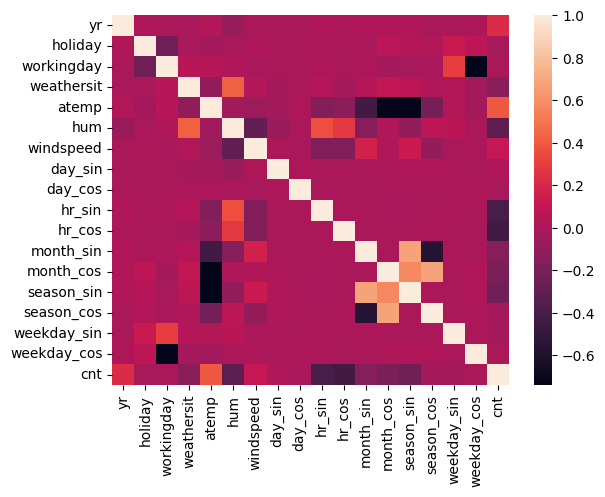

In [34]:
corr_map_2 = pd.merge(X,y,left_index=True,right_index=True).corr()
sns.heatmap(corr_map_2)

In [52]:

n_of_splits = 10
tscv = TimeSeriesSplit(n_splits= n_of_splits)
mse_train_list = []
mse_test_list = []
y_test_list = []
y_pred_list = []
X_test_list = []
y_log = np.log1p(y)
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    # print(f"Fold {i}:")
    # print(f"  Train: index={train_index}")
    # print(f"  Test:  index={test_index}")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = XGBRegressor()
    model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_test_list.append(y_test)
    y_pred_list.append(y_pred_test)
    X_test_list.append(X_test)
    mse_train = np.sqrt(mean_squared_log_error(y_train, y_pred_train))
    mse_test = np.sqrt(mean_squared_log_error(y_test, y_pred_test))
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)
plt.title('RMLSE')
sns.lineplot(x=range(n_of_splits),y=np.sqrt(mse_train_list),label = 'Train')
sns.lineplot(x=range(n_of_splits),y=np.sqrt(mse_test_list),label = 'Test')
plt.show()

ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

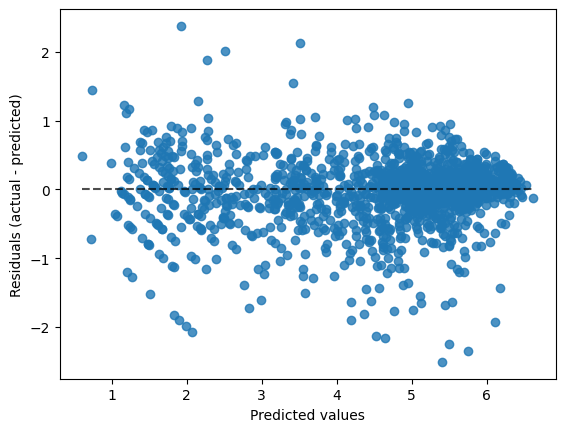

In [38]:
display = PredictionErrorDisplay(y_true=np.array(y_test_list[-1]).flatten(), y_pred=np.array(y_pred_list[-1]).flatten())
display.plot()
plt.show()

<Axes: >

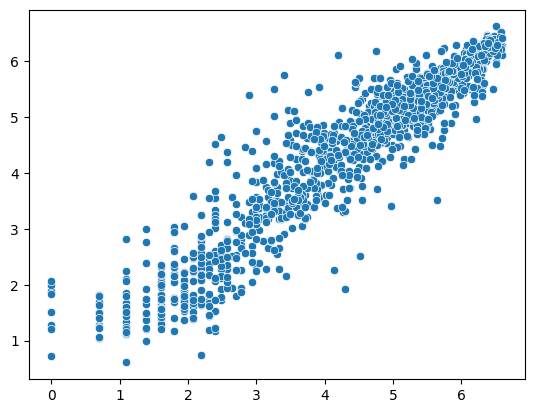

In [39]:
sns.scatterplot(x=np.array(y_test_list[-1]).flatten(), y=np.array(y_pred_list[-1]).flatten())

##Optuna trial

In [40]:
def objective(trial):
    n_of_splits = 10
    tscv = TimeSeriesSplit(n_splits= n_of_splits)
    mse_train_list = []
    mse_test_list = []
    y_test_list = []
    y_pred_list = []
    X_test_list = []
    X_train,X_test,y_train,y_test = None,None,None,None
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
      if i != n_of_splits - 1:
        continue
      else:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)

    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 3.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 3.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    mse = mean_squared_error(y_test, preds)
    return mse


if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2024-08-01 06:44:28,029] A new study created in memory with name: no-name-7341892c-14e7-4dd9-b533-f265fc157ec8
[I 2024-08-01 06:44:28,147] Trial 0 finished with value: 2.033941886552791 and parameters: {'booster': 'gbtree', 'lambda': 0.0008060553251647634, 'alpha': 0.27777204446556414, 'subsample': 0.6121095245517147, 'colsample_bytree': 0.21861239717746417, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.006888812751533692, 'gamma': 2.0307277241559043e-08, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 2.033941886552791.
[I 2024-08-01 06:44:28,189] Trial 1 finished with value: 1.074866099686638 and parameters: {'booster': 'gblinear', 'lambda': 2.9516199263679608e-06, 'alpha': 0.15978634669185718, 'subsample': 0.9181437065807019, 'colsample_bytree': 0.36194737401263066}. Best is trial 1 with value: 1.074866099686638.
[I 2024-08-01 06:44:28,236] Trial 2 finished with value: 0.8978234925482944 and parameters: {'booster': 'gblinear', 'lambda': 0.0007557084884841592, 'alpha': 

Number of finished trials:  100
Best trial:
  Value: 0.247695369106327
  Params: 
    booster: gbtree
    lambda: 1.1789319627257129e-07
    alpha: 0.004041044376559996
    subsample: 0.7344162087692991
    colsample_bytree: 0.9509608753378136
    max_depth: 5
    min_child_weight: 4
    eta: 0.7866099043020319
    gamma: 0.042983533286490065
    grow_policy: lossguide


In [41]:
trial.params

{'booster': 'gbtree',
 'lambda': 1.1789319627257129e-07,
 'alpha': 0.004041044376559996,
 'subsample': 0.7344162087692991,
 'colsample_bytree': 0.9509608753378136,
 'max_depth': 5,
 'min_child_weight': 4,
 'eta': 0.7866099043020319,
 'gamma': 0.042983533286490065,
 'grow_policy': 'lossguide'}

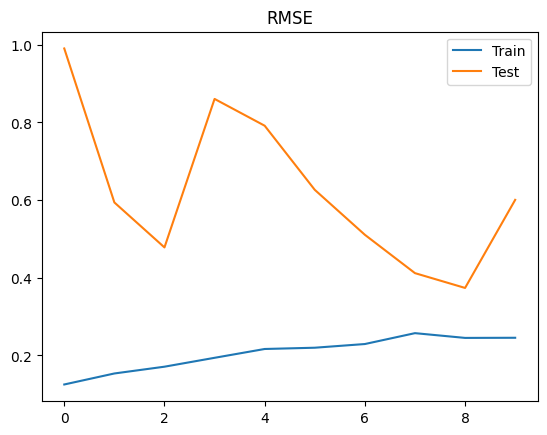

In [42]:
n_of_splits = 10
tscv = TimeSeriesSplit(n_splits= n_of_splits)
mse_train_list = []
mse_test_list = []
y_test_list = []
y_pred_list = []
X_test_list = []
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    # print(f"Fold {i}:")
    # print(f"  Train: index={train_index}")
    # print(f"  Test:  index={test_index}")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = XGBRegressor(**trial.params)
    model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_test_list.append(y_test)
    y_pred_list.append(y_pred_test)
    X_test_list.append(X_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)
plt.title('RMSE')
sns.lineplot(x=range(n_of_splits),y=np.sqrt(mse_train_list),label = 'Train')
sns.lineplot(x=range(n_of_splits),y=np.sqrt(mse_test_list),label = 'Test')
plt.show()

In [85]:
pred = model.predict(X_test, output_margin=True)

explainer = shap.TreeExplainer(model)
explanation = explainer(X_test)

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

0.0004272461

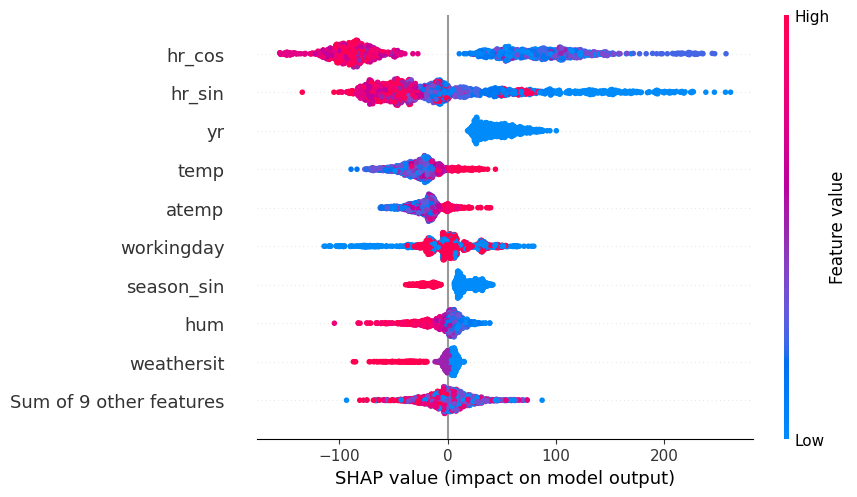

In [86]:
shap.plots.beeswarm(explanation)

In [9]:
import torch

In [10]:
def create_dataset(X,y, look_back=7):
    X_ans, y_ans = [], []
    for i in range(len(X)-look_back):
        a,b = X[i:i+look_back],y[i + 1:i+ 1 +look_back]
        X_ans.append(a)
        y_ans.append(b)
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    return torch.tensor(np.array(X_ans),dtype=torch.float32,device = device),torch.tensor(np.array(y_ans),dtype=torch.float32,device = device)

In [11]:
tensor_X, tensor_y = create_dataset(X,y)

In [84]:
tensor_X.dtype

torch.float32

In [20]:
import torch.nn as nn

class AirModel(nn.Module):
    def __init__(self,device):
        super().__init__()
        self.device = device
        self.lstm = nn.LSTM(input_size=18, hidden_size=50, num_layers=1,batch_first=True,device = self.device)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [31]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
torch.manual_seed(0)
torch.device('cuda')
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
loss_fn = nn.MSELoss()
n_of_splits = 10
tscv = TimeSeriesSplit(n_splits= n_of_splits)
for i, (train_index, test_index) in enumerate(tscv.split(tensor_X)):
    model = AirModel(device)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters())
    X_train, X_test = tensor_X[train_index], tensor_X[test_index]
    y_train, y_test = tensor_y[train_index], tensor_y[test_index]
    loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
    n_epochs = 300
    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Validation
        if epoch % 100 != 0:
            continue
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            train_rmse = np.sqrt(loss_fn(y_pred.cpu(), y_train.cpu()))
            y_pred = model(X_test)
            test_rmse = np.sqrt(loss_fn(y_pred.cpu(), y_test.cpu()))
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 78.9380, test RMSE 168.9592
Epoch 100: train RMSE 16.9792, test RMSE 98.9458
Epoch 200: train RMSE 10.8836, test RMSE 101.7135
Epoch 0: train RMSE 125.1815, test RMSE 231.8204
Epoch 100: train RMSE 17.8172, test RMSE 84.3468
Epoch 200: train RMSE 12.3189, test RMSE 88.0202
Epoch 0: train RMSE 162.7307, test RMSE 207.4665
Epoch 100: train RMSE 21.6217, test RMSE 65.7589
Epoch 200: train RMSE 15.7593, test RMSE 68.5418


KeyboardInterrupt: 